# Corporación Favorita Time Series - Feature Engineering

***
<br>




<img src="../../reports/img/Corporación_Favorita_Logo.png" width=400 height=300 />

<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This section comes after the Exploratory Data Analysis (EDA) step. In the following lines of code you will find the steps I took in terms of preprocessing the available data. What we want to achieve is actually a clean dataset that our machine learning models can analyze well. A reminder that our final goal is create a machine learning model that determines if we can classify MBTI types taking into consideration the posts made by each person.<p>
</div>

<br>

### Table of Contents

- [Importing Libraries](#importing)
- [Importing Data](#data)
- [Stationarity Test](#stationarity)
- [Correcting Stationarity](#correcting)
- [Decomposition: trend, seasonality, residuals](#decomposition)
- [Saving new data](#saving)

<a id='importing'></a>

## Importing libraries

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="Progress!")
import os.path
from datetime import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

#Settings
sns.set()
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

/Users/diego/.pyenv/versions/venv-time-series/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


<a id='data'></a>

## Importing Data

***

In [2]:
# We load the datasets
train = pd.read_csv('../../data/train_clean.csv', parse_dates=['date'], date_parser=dateparse,  dtype={'id': int, 'store_nbr': int, 'item_nbr': int, 'unit_sales': float, 'onpromotion':object})
test = pd.read_csv('../../data/test.csv', parse_dates=['date'], date_parser=dateparse)

In [3]:
train = train.drop('Unnamed: 0', axis=1).set_index('date')
test = test.drop('Unnamed: 0', axis=1).set_index('date')

In [4]:
train.head()

id  item_nbr  unit_sales onpromotion        family  class  \
date                                                                     
2013-01-02  578    103665         2.0     No Info  BREAD/BAKERY   2712   
2013-01-02  579    105574         8.0     No Info     GROCERY I   1045   
2013-01-02  580    105575        15.0     No Info     GROCERY I   1045   
2013-01-02  581    105577         2.0     No Info     GROCERY I   1045   
2013-01-02  582    105737         2.0     No Info     GROCERY I   1044   

            perishable  price  transactions      type  dow  
date                                                        
2013-01-02           1  93.14        2111.0  Work Day    2  
2013-01-02           0  93.14        2111.0  Work Day    2  
2013-01-02           0  93.14        2111.0  Work Day    2  
2013-01-02           0  93.14        2111.0  Work Day    2  
2013-01-02           0  93.14        2111.0  Work Day    2

In [5]:
test.head()

id  store_nbr  item_nbr  onpromotion
date                                                   
2017-08-16  125497040          1     96995        False
2017-08-16  125497041          1     99197        False
2017-08-16  125497042          1    103501        False
2017-08-16  125497043          1    103520        False
2017-08-16  125497044          1    103665        False

In [6]:
#we will also import the oil dataset to test some of our functions
oil = pd.read_csv('../../data/oil.csv', parse_dates=['date'], date_parser=dateparse)
oil = oil.set_index('date')

<a id='stationarity'></a>

<div class='alert alert-info'>
    <p>Note: The following theory and code snippets come from <a href='https://tklouie.github.io/'>Tamara Louie</a> and her <a href='https://www.youtube.com/watch?v=JntA9XaTebs&t=3435s'>2018 PyData talk </a></p>
</div>

## Stationarity Test
***

Most time-series models assume that the underlying time-series data is stationary. Stationarity is a statistical assumption that a time-series has:

- Constant mean
- Constant variance
- Autocovariance does not depend on time

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. This general statement holds for most training data and modeling tasks. 

**From Duke University:** [link](https://people.duke.edu/~rnau/411diff.htm) 
- The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. 
- Another reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary.


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts, save_as):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(12,8))
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.savefig('img/stationarity/%s Rolling Mean & Standard Deviation for %s' %(save_as, ts))
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

<br>

We will start by testing the function on the oil dataset which is clearly non stationary.

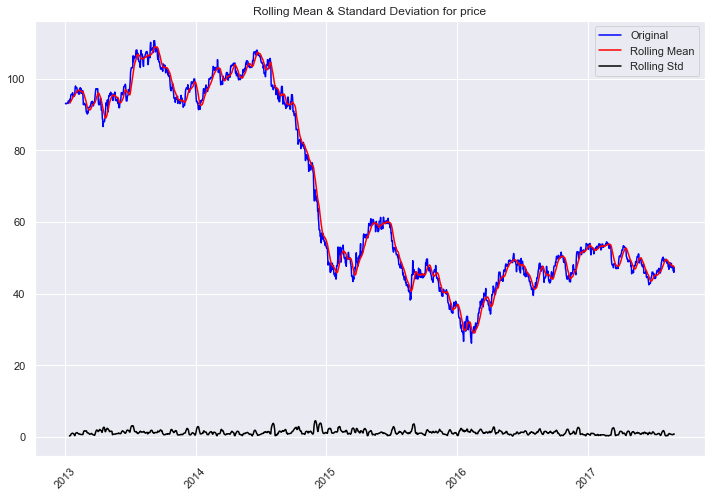

Results of Dickey-Fuller Test:
Test Statistic                   -0.878759
p-value                           0.794887
# Lags Used                       1.000000
Number of Observations Used    1701.000000
Critical Value (1%)              -3.434200
Critical Value (5%)              -2.863241
Critical Value (10%)             -2.567675
dtype: float64


In [8]:
test_stationarity(oil.iloc[1:], ts='price', save_as='oil_price')

In [9]:
product_families = train.family.unique().tolist()
product_families

['BREAD/BAKERY',
 'GROCERY I',
 'DELI',
 'CLEANING',
 'POULTRY',
 'PERSONAL CARE',
 'BEVERAGES',
 'AUTOMOTIVE',
 'DAIRY',
 'EGGS',
 'GROCERY II',
 'LINGERIE',
 'SEAFOOD',
 'FROZEN FOODS',
 'PREPARED FOODS',
 'MEATS',
 'BEAUTY',
 'LIQUOR,WINE,BEER',
 'HARDWARE',
 'LAWN AND GARDEN',
 'HOME APPLIANCES',
 'PRODUCE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'MAGAZINES',
 'HOME CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'CELEBRATION',
 'LADIESWEAR',
 'SCHOOL AND OFFICE SUPPLIES',
 'BOOKS']

In [10]:
hk = train[train['family'] == 'HOME AND KITCHEN II'][['unit_sales']].groupby('date').mean()

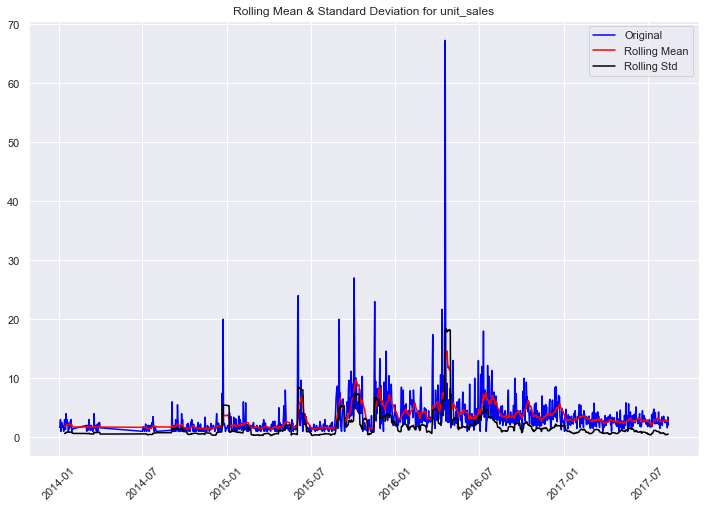

Results of Dickey-Fuller Test:
Test Statistic                -5.676095e+00
p-value                        8.698071e-07
# Lags Used                    1.000000e+01
Number of Observations Used    1.142000e+03
Critical Value (1%)           -3.436089e+00
Critical Value (5%)           -2.864074e+00
Critical Value (10%)          -2.568119e+00
dtype: float64


In [11]:
test_stationarity(hk, ts='unit_sales', save_as='home_and_kitchen')

In [12]:
def adfuller_group(dataset, column, list_to_analyse):
    
    for i in list_to_analyse:
        analyse = dataset[dataset['family'] == i][[column]].groupby('date').mean()
        dftest = adfuller(analyse[column], autolag='AIC')
        print(i, ' p_value', dftest[1:2])

In [13]:
adfuller_group(train, 'unit_sales', list_to_analyse=product_families)

BREAD/BAKERY  p_value (0.0005218444678409643,)
GROCERY I  p_value (1.6437845477098352e-07,)
DELI  p_value (0.01670982392439669,)
CLEANING  p_value (8.987083504992601e-07,)
POULTRY  p_value (0.32572174178027014,)
PERSONAL CARE  p_value (5.084981853953075e-06,)
BEVERAGES  p_value (7.948500173760226e-07,)
AUTOMOTIVE  p_value (0.0,)
DAIRY  p_value (0.0003317809675335494,)
EGGS  p_value (0.004207177368505375,)
GROCERY II  p_value (6.573289376046374e-10,)
LINGERIE  p_value (6.5626975813844975e-12,)
SEAFOOD  p_value (5.314018513306975e-11,)
FROZEN FOODS  p_value (6.5887571151441745e-15,)
PREPARED FOODS  p_value (9.477030631867805e-06,)
MEATS  p_value (0.0002579651877046899,)
BEAUTY  p_value (2.07483454544013e-29,)
LIQUOR,WINE,BEER  p_value (8.701784482289522e-05,)
HARDWARE  p_value (3.7966474793487618e-19,)
LAWN AND GARDEN  p_value (2.350704927308478e-05,)
HOME APPLIANCES  p_value (0.0,)
PRODUCE  p_value (0.001453063992076531,)
HOME AND KITCHEN I  p_value (0.0,)
HOME AND KITCHEN II  p_value (

Based on Dickey-Fuller test, we can see that except Poultry and Books, all of the other family groups are stationary.

<a id='correcting'></a>

## Correcting for stationarity
***

Although our case was a bit different, it is common for time series data to have to correct for non-stationarity.

#### 2 common reasons behind non-stationarity are:

- Trend – mean is not constant over time.
- Seasonality – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

#### What happens if you do not correct for these things?

Many things can happen, including:

- Variance can be mis-specified
- Model fit can be worse.
- Not leveraging valuable time-dependent nature of the data.
- Here are some resources on the pitfalls of using traditional methods for time series analysis.
 - [Quora](https://www.quora.com/Why-cant-you-use-linear-regression-for-time-series-data)
 - [Quora](https://www.quora.com/Data-Science-Can-machine-learning-be-used-for-time-series-analysis)

#### Eliminating trend and seasonality
**Transformation**
- Examples. Log, square root, etc.

**Smoothing**
- Examples. Weekly average, monthly average, rolling averages.

**Differencing**
- Examples. First-order differencing.

**Polynomial Fitting**
- Examples. Fit a regression model.

**Decomposition**


In [14]:
def plot_transformed_data(df, ts, ts_transform, save_as):
    """
    Plot transformed and original time series data
    """
    # Plot time series data
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

    # Add title
    ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

    # Rotate x-labels
    ax.tick_params(axis = 'x', rotation = 45)

    # Add legend
    ax.legend([ts, ts_transform])
    
    # Save figure
    plt.savefig('img/transformed_data/%s %s and %s time-series graph' %(save_as, ts, ts_transform))
    
    plt.show()
    plt.close()
    
    return

In [15]:
def ts_transformations(dataframe, column, save_as):
    # Transformation - log ts
    dataframe['ts_log'] = dataframe[column].apply(lambda x: np.log(x))

    # Transformation - 7-day moving averages of log ts
    dataframe['ts_log_moving_avg'] = dataframe['ts_log'].rolling(window = 7, center = False).mean()

    # Transformation - 7-day moving average ts
    dataframe['ts_moving_avg'] = dataframe[column].rolling(window = 7, center = False).mean()

    # Transformation - Difference between logged ts and first-order difference logged ts
    # df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
    dataframe['ts_log_diff'] = dataframe['ts_log'].diff()

    # Transformation - Difference between ts and moving average ts
    dataframe['ts_moving_avg_diff'] = dataframe[column] - dataframe['ts_moving_avg']

    # Transformation - Difference between logged ts and logged moving average ts
    dataframe['ts_log_moving_avg_diff'] = dataframe['ts_log'] - dataframe['ts_log_moving_avg']

    # Transformation - Difference between logged ts and logged moving average ts
    df_example_transform = dataframe.dropna()

    # Transformation - Logged exponentially weighted moving averages (EWMA) ts
    df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                             ignore_na = False,
                                                                             min_periods = 0,
                                                                             adjust = True).mean()

    # Transformation - Difference between logged ts and logged EWMA ts
    df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

    # Display data
    display(df_example_transform.head())

    # Plot data
    plot_transformed_data(df = dataframe, 
                          ts = column, 
                          ts_transform = 'ts_log',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = dataframe, 
                          ts = 'ts_log', 
                          ts_transform = 'ts_log_moving_avg',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = column, 
                          ts_transform = 'ts_moving_avg',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = 'ts_log', 
                          ts_transform = 'ts_log_diff',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = column, 
                          ts_transform = 'ts_moving_avg_diff',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = 'ts_log', 
                          ts_transform = 'ts_log_moving_avg_diff',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = 'ts_log', 
                          ts_transform = 'ts_log_ewma',
                         save_as=save_as)
    # Plot data
    plot_transformed_data(df = df_example_transform, 
                          ts = 'ts_log', 
                          ts_transform = 'ts_log_ewma_diff',
                         save_as=save_as)
    
    # Perform stationarity test
    test_stationarity(df = df_example_transform, 
                      ts = 'ts_log',
                     save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform, 
                      ts = 'ts_moving_avg',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform, 
                      ts = 'ts_log_moving_avg',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform,
                      ts = 'ts_log_diff',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform,
                      ts = 'ts_moving_avg_diff',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform,
                      ts = 'ts_log_moving_avg_diff',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform, 
                      ts = 'ts_log_ewma',
                      save_as=save_as)

    # Perform stationarity test
    test_stationarity(df = df_example_transform,
                      ts = 'ts_log_ewma_diff',
                      save_as=save_as)

In [16]:
poultry = train[train['family'] == 'POULTRY'][['unit_sales']].groupby('date').mean()
books = train[train['family'] == 'BOOKS'][['unit_sales']].groupby('date').mean()

unit_sales    ts_log  ts_log_moving_avg  ts_moving_avg  \
date                                                                 
2013-01-08   16.596800  2.809210           3.000253      20.901366   
2013-01-09   23.030556  3.136822           2.975033      20.266096   
2013-01-10   17.341333  2.853093           2.990091      20.513929   
2013-01-11   17.956700  2.887963           2.951921      19.728224   
2013-01-12   17.505750  2.862529           2.909292      18.858681   

            ts_log_diff  ts_moving_avg_diff  ts_log_moving_avg_diff  \
date                                                                  
2013-01-08    -0.497187           -4.304566               -0.191044   
2013-01-09     0.327612            2.764459                0.161789   
2013-01-10    -0.283729           -3.172596               -0.136998   
2013-01-11     0.034870           -1.771524               -0.063958   
2013-01-12    -0.025434           -1.352931               -0.046763   

            ts_log_ewma  ts_log_ewma_diff  
date                                       
2013-01-08     2.809210          0.000000  
2013-01-09     2.981119          0.155702  
2013-01-10     2.934155         -0.081063  
2013-01-11     2.920840         -0.032877  
2013-01-12     2.906762         -0.044233

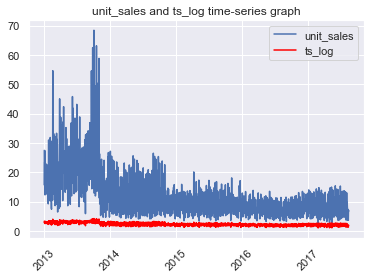

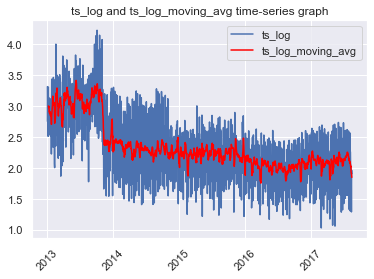

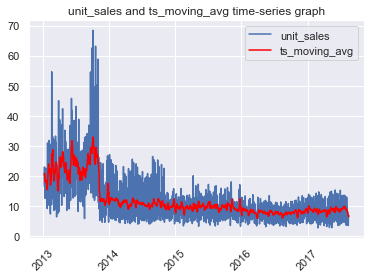

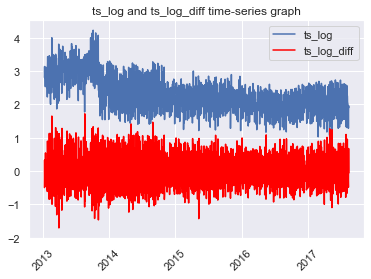

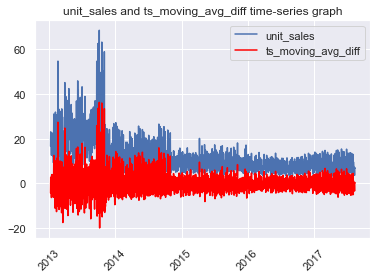

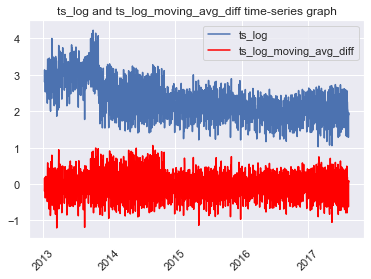

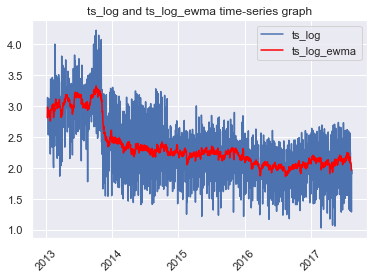

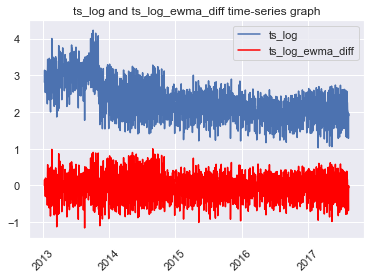

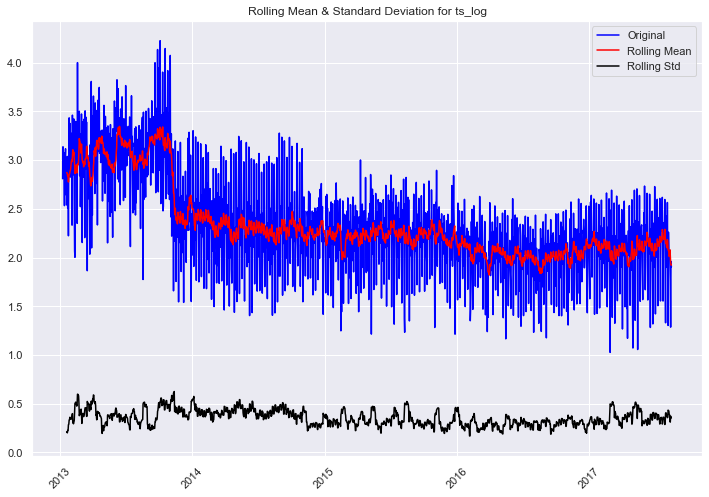

Results of Dickey-Fuller Test:
Test Statistic                   -1.856505
p-value                           0.352791
# Lags Used                      23.000000
Number of Observations Used    1648.000000
Critical Value (1%)              -3.434324
Critical Value (5%)              -2.863295
Critical Value (10%)             -2.567705
dtype: float64


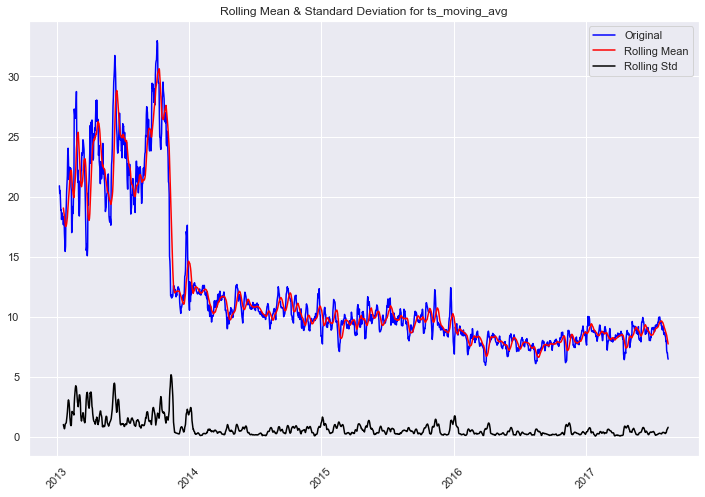

Results of Dickey-Fuller Test:
Test Statistic                   -2.166690
p-value                           0.218556
# Lags Used                      25.000000
Number of Observations Used    1646.000000
Critical Value (1%)              -3.434329
Critical Value (5%)              -2.863298
Critical Value (10%)             -2.567706
dtype: float64


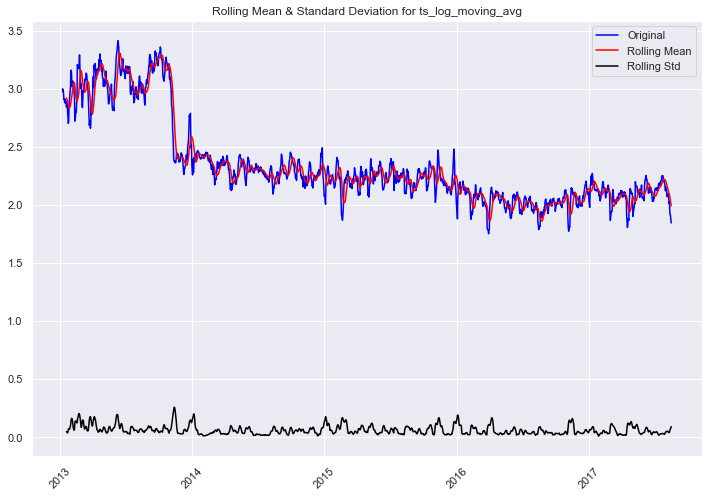

Results of Dickey-Fuller Test:
Test Statistic                   -1.833954
p-value                           0.363739
# Lags Used                      25.000000
Number of Observations Used    1646.000000
Critical Value (1%)              -3.434329
Critical Value (5%)              -2.863298
Critical Value (10%)             -2.567706
dtype: float64


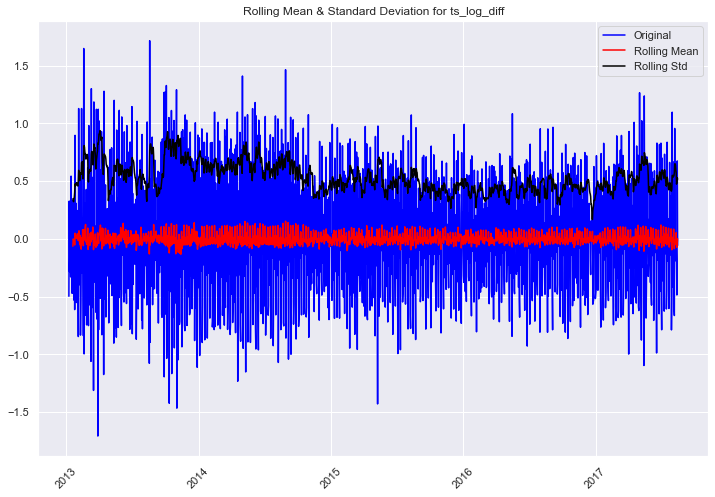

Results of Dickey-Fuller Test:
Test Statistic                -1.237155e+01
p-value                        5.267526e-23
# Lags Used                    2.200000e+01
Number of Observations Used    1.649000e+03
Critical Value (1%)           -3.434322e+00
Critical Value (5%)           -2.863294e+00
Critical Value (10%)          -2.567704e+00
dtype: float64


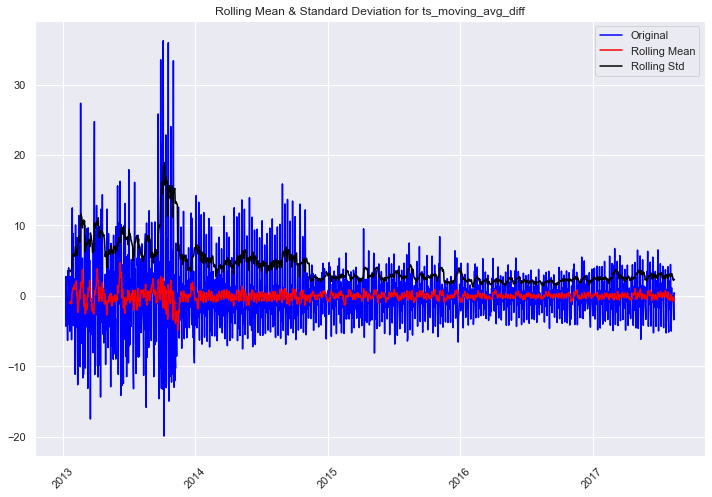

Results of Dickey-Fuller Test:
Test Statistic                -1.017897e+01
p-value                        6.773825e-18
# Lags Used                    2.400000e+01
Number of Observations Used    1.647000e+03
Critical Value (1%)           -3.434327e+00
Critical Value (5%)           -2.863296e+00
Critical Value (10%)          -2.567705e+00
dtype: float64


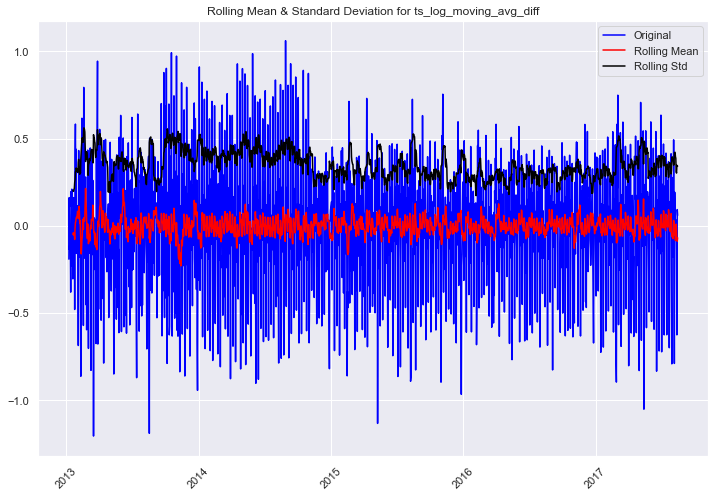

Results of Dickey-Fuller Test:
Test Statistic                -1.164140e+01
p-value                        2.142621e-21
# Lags Used                    2.400000e+01
Number of Observations Used    1.647000e+03
Critical Value (1%)           -3.434327e+00
Critical Value (5%)           -2.863296e+00
Critical Value (10%)          -2.567705e+00
dtype: float64


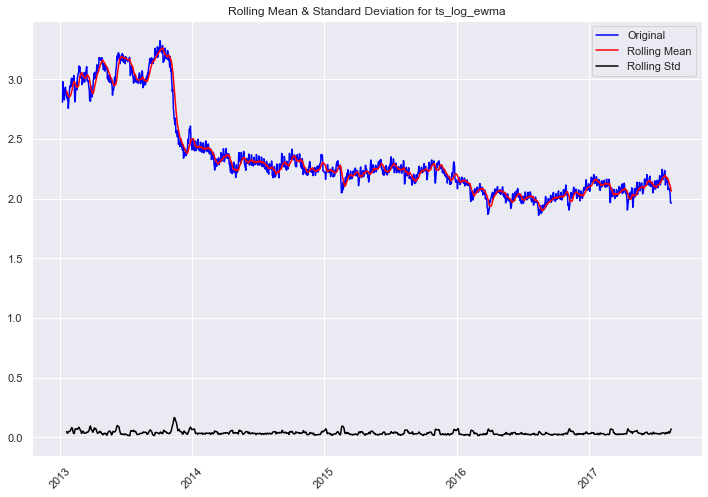

Results of Dickey-Fuller Test:
Test Statistic                   -1.673909
p-value                           0.444603
# Lags Used                      25.000000
Number of Observations Used    1646.000000
Critical Value (1%)              -3.434329
Critical Value (5%)              -2.863298
Critical Value (10%)             -2.567706
dtype: float64


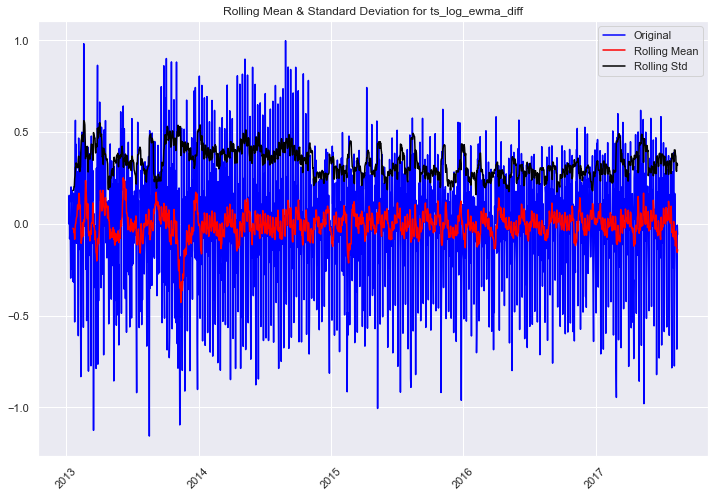

Results of Dickey-Fuller Test:
Test Statistic                -8.483367e+00
p-value                        1.373975e-13
# Lags Used                    2.400000e+01
Number of Observations Used    1.647000e+03
Critical Value (1%)           -3.434327e+00
Critical Value (5%)           -2.863296e+00
Critical Value (10%)          -2.567705e+00
dtype: float64


In [17]:
ts_transformations(dataframe=poultry, column='unit_sales', save_as='poultry')

unit_sales    ts_log  ts_log_moving_avg  ts_moving_avg  \
date                                                                 
2016-10-20         1.0  0.000000           0.652050       2.000000   
2016-10-21         3.0  1.098612           0.709973       2.142857   
2016-10-22         2.0  0.693147           0.709973       2.142857   
2016-10-24         1.0  0.000000           0.553029       1.857143   
2016-10-25         2.0  0.693147           0.553029       1.857143   

            ts_log_diff  ts_moving_avg_diff  ts_log_moving_avg_diff  \
date                                                                  
2016-10-20    -0.693147           -1.000000               -0.652050   
2016-10-21     1.098612            0.857143                0.388639   
2016-10-22    -0.405465           -0.142857               -0.016826   
2016-10-24    -0.693147           -0.857143               -0.553029   
2016-10-25     0.693147            0.142857                0.140118   

            ts_log_ewma  ts_log_ewma_diff  
date                                       
2016-10-20     0.000000          0.000000  
2016-10-21     0.576480          0.522132  
2016-10-22     0.619277          0.073870  
2016-10-24     0.440763         -0.440763  
2016-10-25     0.501696          0.191452

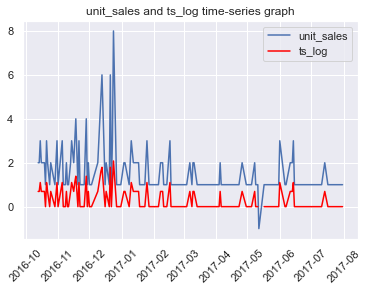

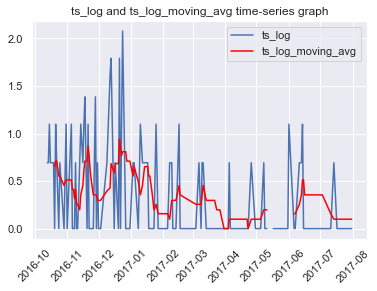

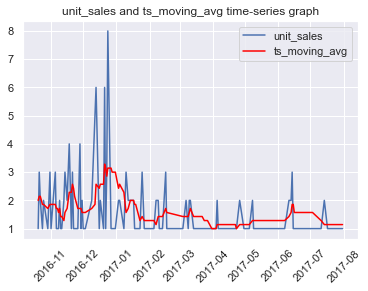

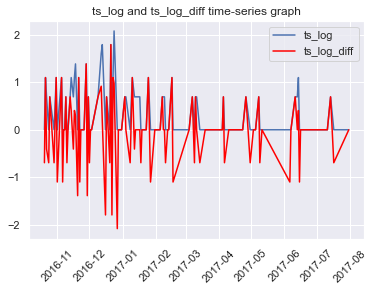

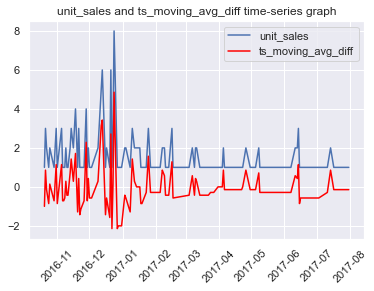

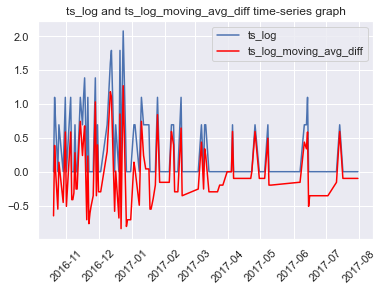

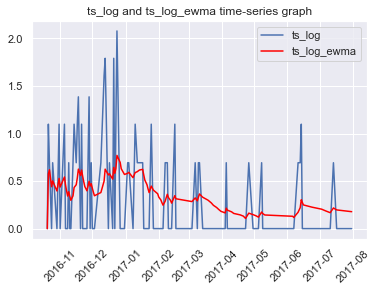

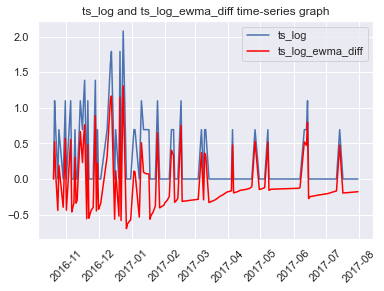

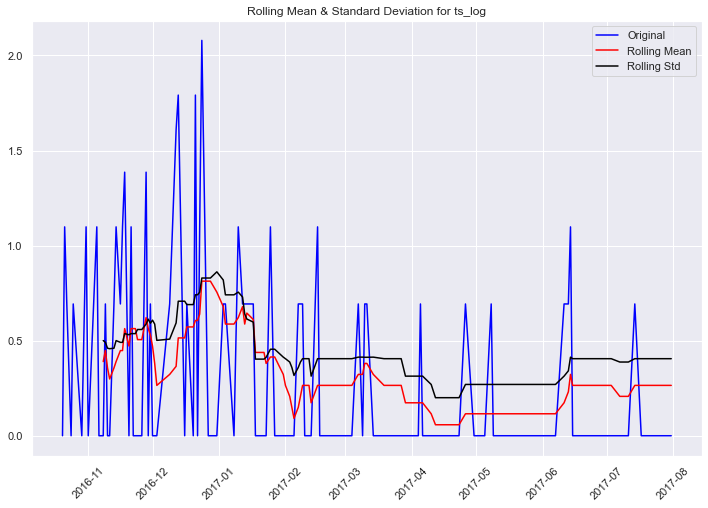

Results of Dickey-Fuller Test:
Test Statistic                -9.845278e+00
p-value                        4.637395e-17
# Lags Used                    0.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


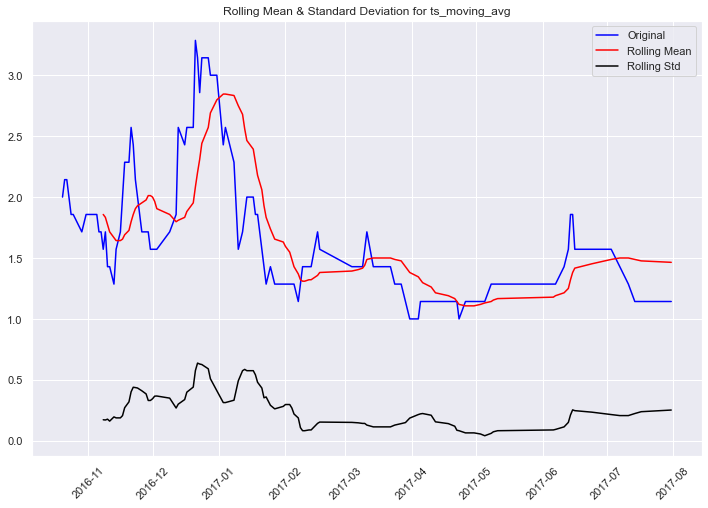

Results of Dickey-Fuller Test:
Test Statistic                  -1.832339
p-value                          0.364528
# Lags Used                      0.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


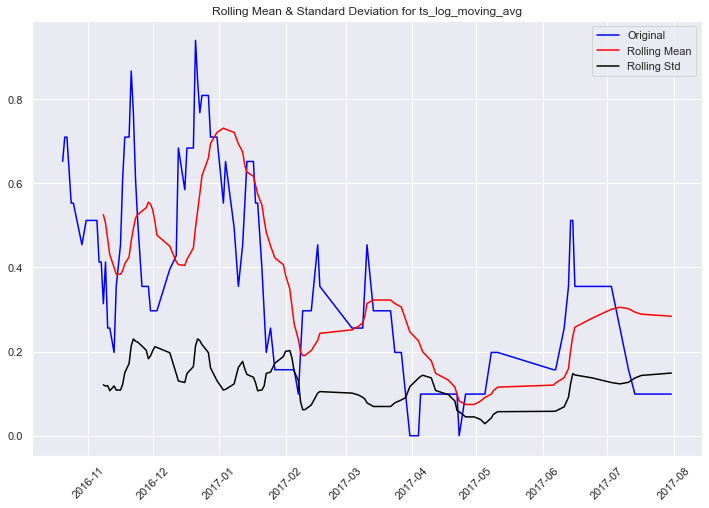

Results of Dickey-Fuller Test:
Test Statistic                  -2.832964
p-value                          0.053717
# Lags Used                      2.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


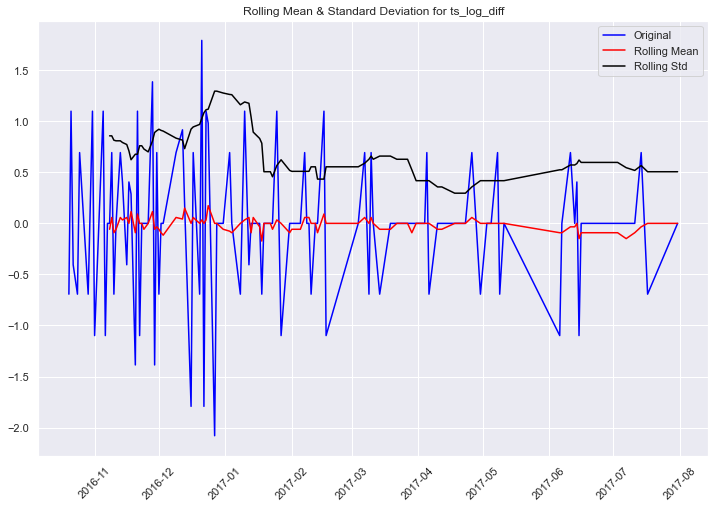

Results of Dickey-Fuller Test:
Test Statistic                -8.274727e+00
p-value                        4.689835e-13
# Lags Used                    5.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


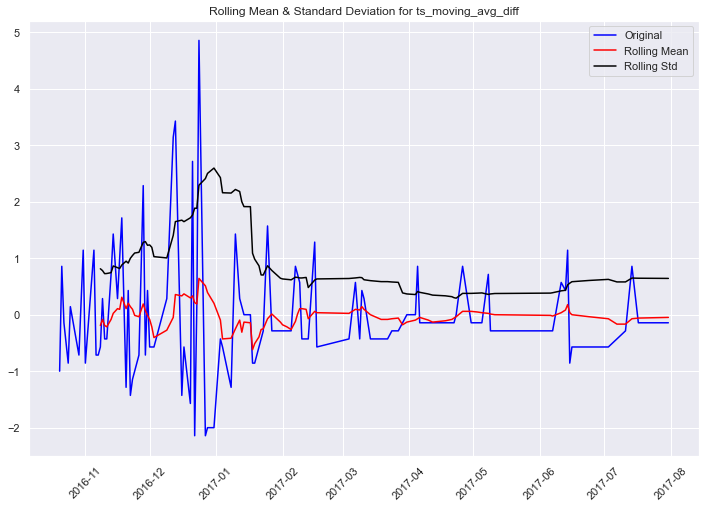

Results of Dickey-Fuller Test:
Test Statistic                  -4.417843
p-value                          0.000276
# Lags Used                      6.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


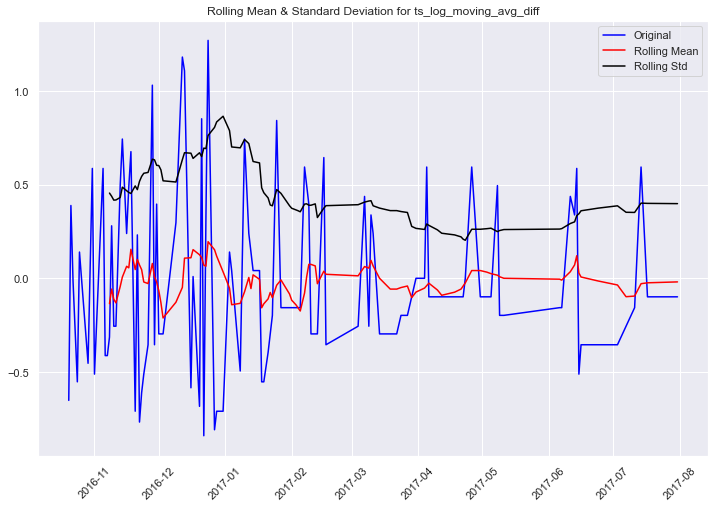

Results of Dickey-Fuller Test:
Test Statistic                  -4.608482
p-value                          0.000125
# Lags Used                      8.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


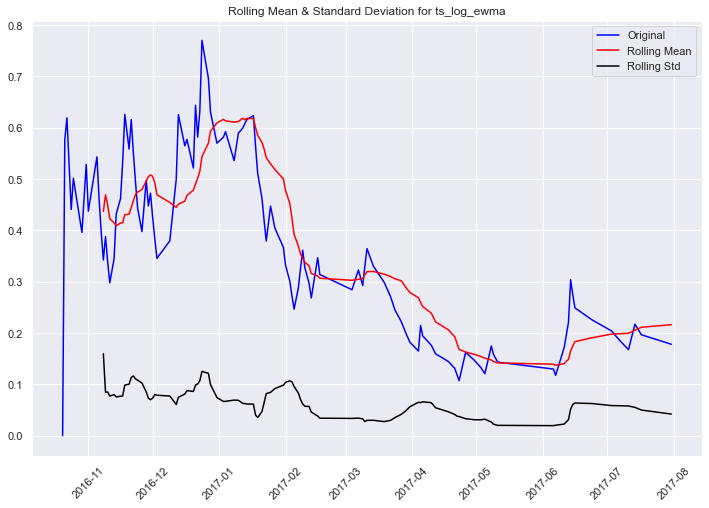

Results of Dickey-Fuller Test:
Test Statistic                  -2.900513
p-value                          0.045288
# Lags Used                      0.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


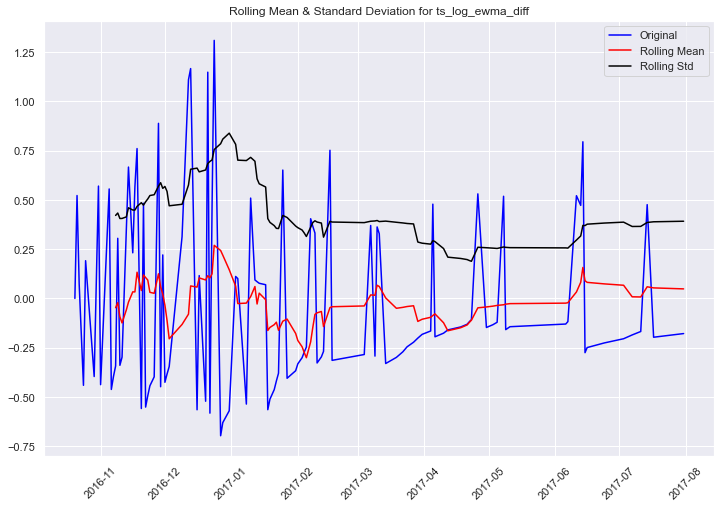

Results of Dickey-Fuller Test:
Test Statistic                -1.086736e+01
p-value                        1.396460e-19
# Lags Used                    0.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


In [18]:
ts_transformations(dataframe=books, column='unit_sales', save_as='books')

<div class="span5 alert alert-success">
<h3>Solution</h3>
As we saw from the previous plots and adfuller tests, there are several transformations that would work for us. For "BOOKS" we will keep the result from a simple log transformation and for "POULTRY" we will use the log transformation and the difference between day n+1 - n.
</div>    

Let's do the same process with the oil prices which we have also seen that it is not stationary

In [19]:
oil.head()

price
date             
2013-01-01    NaN
2013-01-02  93.14
2013-01-03  92.97
2013-01-04  93.12
2013-01-05  93.12

In [20]:
print('oil adfuller test p_value', adfuller(oil['price'].iloc[1:], autolag='AIC')[1])

oil adfuller test p_value 0.7948869249092471


price    ts_log  ts_log_moving_avg  ts_moving_avg  ts_log_diff  \
date                                                                         
2013-01-08  93.21  4.534855           4.533950      93.125714     0.000107   
2013-01-09  93.08  4.533459           4.533858      93.117143    -0.001396   
2013-01-10  93.81  4.541271           4.535143      93.237143     0.007812   
2013-01-11  93.60  4.539030           4.535877      93.305714    -0.002241   
2013-01-12  93.60  4.539030           4.536612      93.374286     0.000000   

            ts_moving_avg_diff  ts_log_moving_avg_diff  ts_log_ewma  \
date                                                                  
2013-01-08            0.084286                0.000905     4.534855   
2013-01-09           -0.037143               -0.000399     4.534123   
2013-01-10            0.572857                0.006129     4.536745   
2013-01-11            0.294286                0.003153     4.537404   
2013-01-12            0.225714                0.002418     4.537797   

            ts_log_ewma_diff  
date                          
2013-01-08          0.000000  
2013-01-09         -0.000663  
2013-01-10          0.004526  
2013-01-11          0.001627  
2013-01-12          0.001234

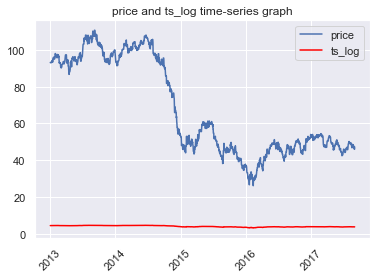

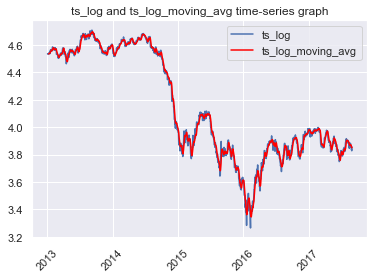

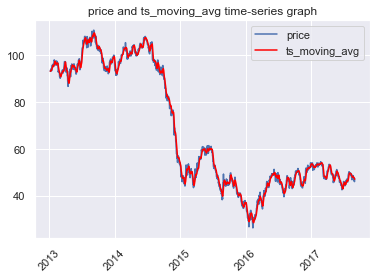

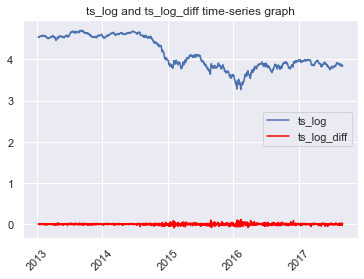

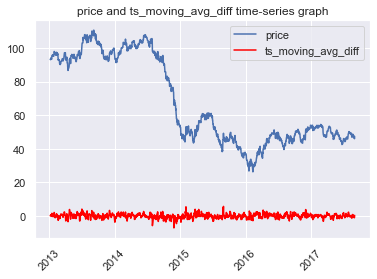

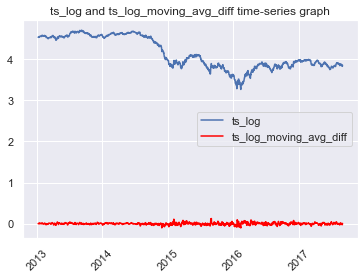

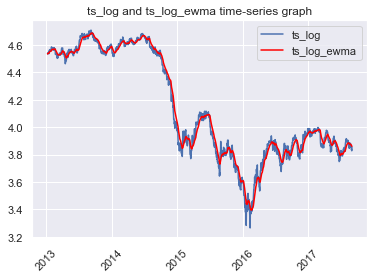

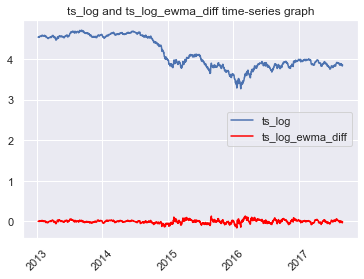

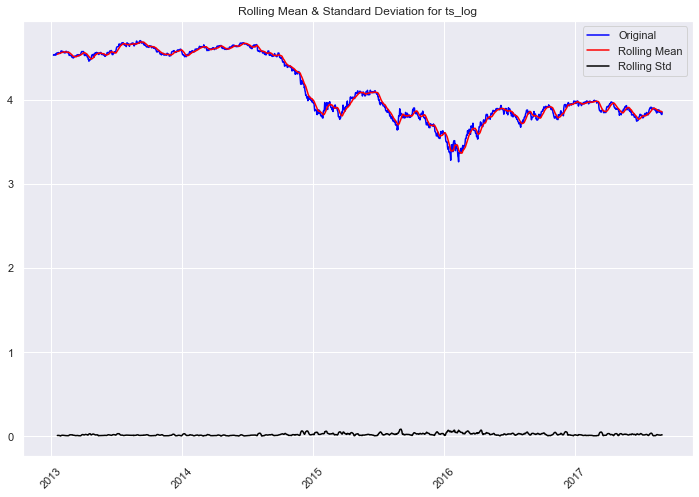

Results of Dickey-Fuller Test:
Test Statistic                   -1.052237
p-value                           0.733739
# Lags Used                       2.000000
Number of Observations Used    1694.000000
Critical Value (1%)              -3.434216
Critical Value (5%)              -2.863248
Critical Value (10%)             -2.567679
dtype: float64


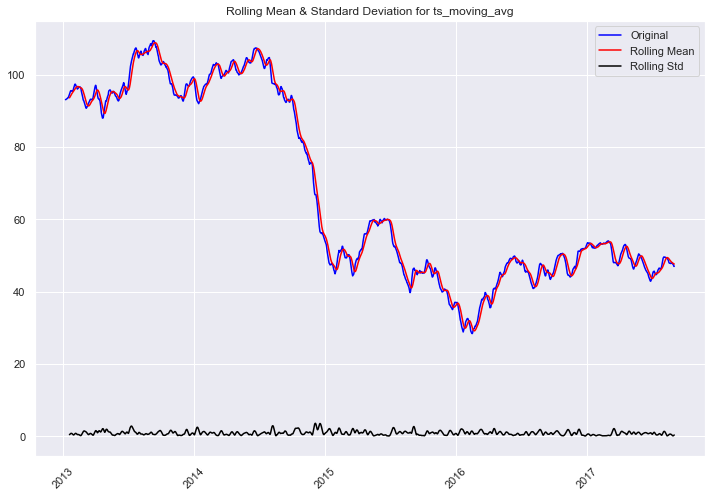

Results of Dickey-Fuller Test:
Test Statistic                   -1.176710
p-value                           0.683534
# Lags Used                      22.000000
Number of Observations Used    1674.000000
Critical Value (1%)              -3.434262
Critical Value (5%)              -2.863268
Critical Value (10%)             -2.567690
dtype: float64


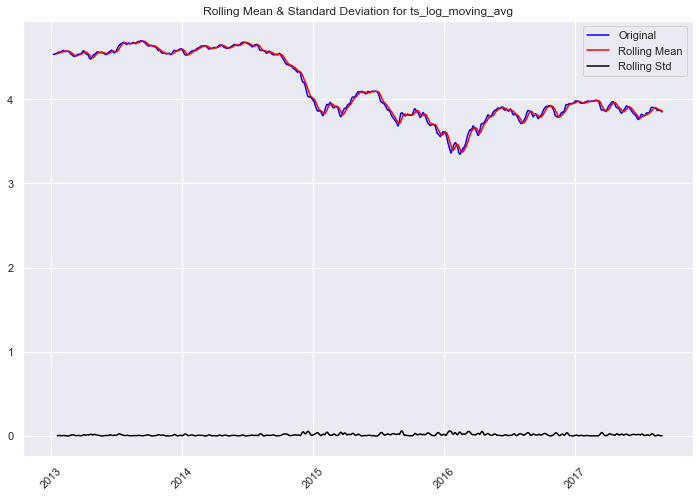

Results of Dickey-Fuller Test:
Test Statistic                   -1.243707
p-value                           0.654517
# Lags Used                      22.000000
Number of Observations Used    1674.000000
Critical Value (1%)              -3.434262
Critical Value (5%)              -2.863268
Critical Value (10%)             -2.567690
dtype: float64


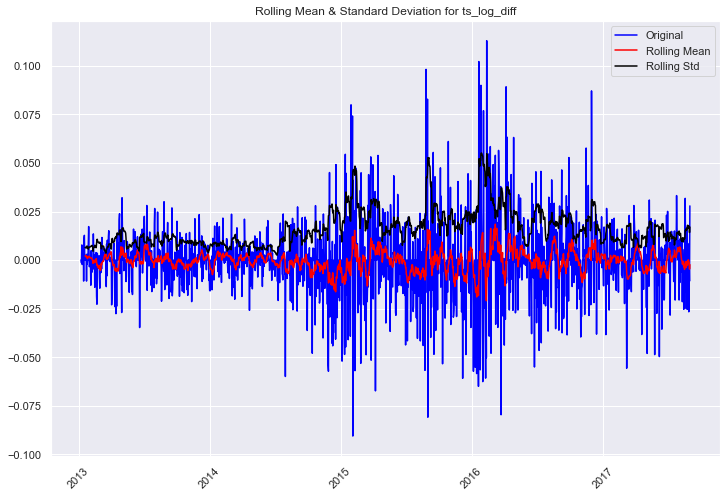

Results of Dickey-Fuller Test:
Test Statistic                  -31.161196
p-value                           0.000000
# Lags Used                       1.000000
Number of Observations Used    1695.000000
Critical Value (1%)              -3.434214
Critical Value (5%)              -2.863247
Critical Value (10%)             -2.567679
dtype: float64


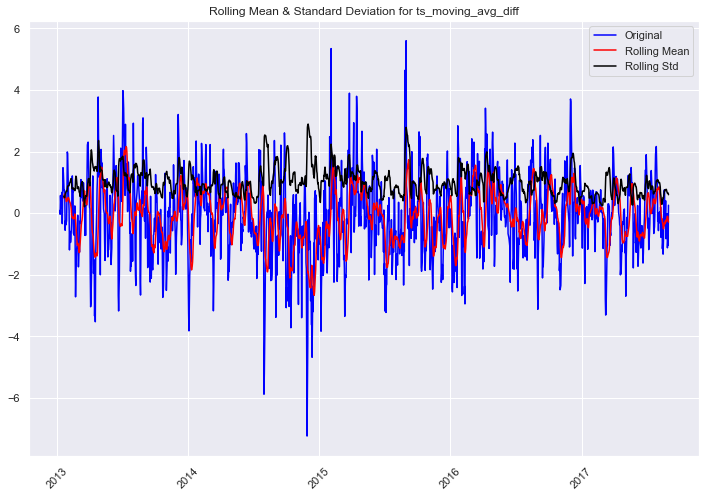

Results of Dickey-Fuller Test:
Test Statistic                -1.093266e+01
p-value                        9.734519e-20
# Lags Used                    7.000000e+00
Number of Observations Used    1.689000e+03
Critical Value (1%)           -3.434228e+00
Critical Value (5%)           -2.863253e+00
Critical Value (10%)          -2.567682e+00
dtype: float64


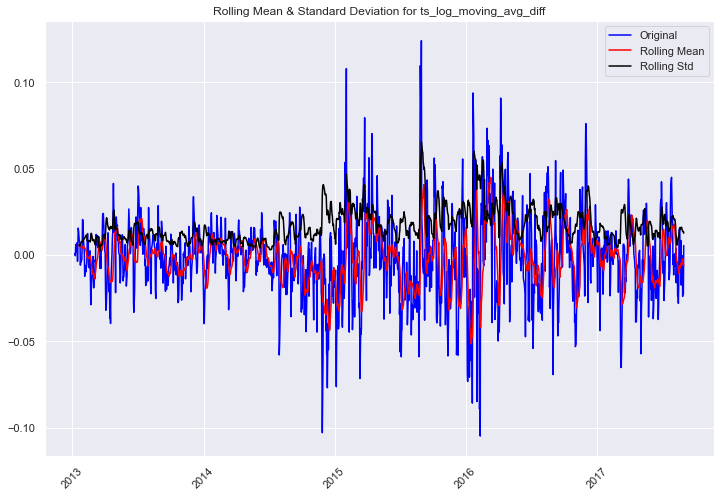

Results of Dickey-Fuller Test:
Test Statistic                -1.191641e+01
p-value                        5.152377e-22
# Lags Used                    6.000000e+00
Number of Observations Used    1.690000e+03
Critical Value (1%)           -3.434225e+00
Critical Value (5%)           -2.863252e+00
Critical Value (10%)          -2.567681e+00
dtype: float64


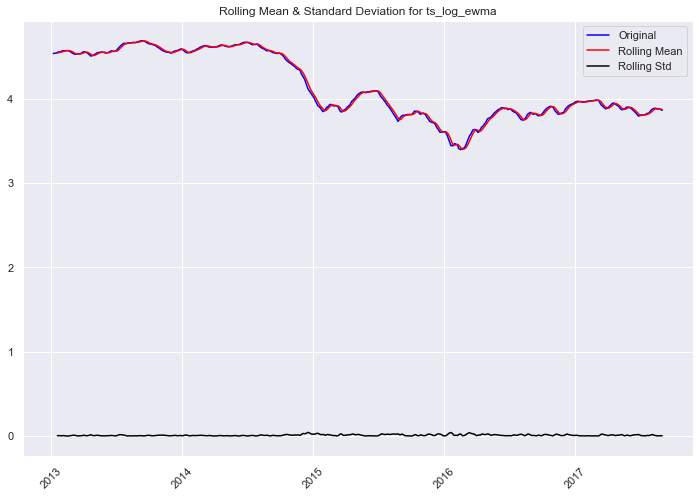

Results of Dickey-Fuller Test:
Test Statistic                   -1.170527
p-value                           0.686144
# Lags Used                       3.000000
Number of Observations Used    1693.000000
Critical Value (1%)              -3.434218
Critical Value (5%)              -2.863249
Critical Value (10%)             -2.567680
dtype: float64


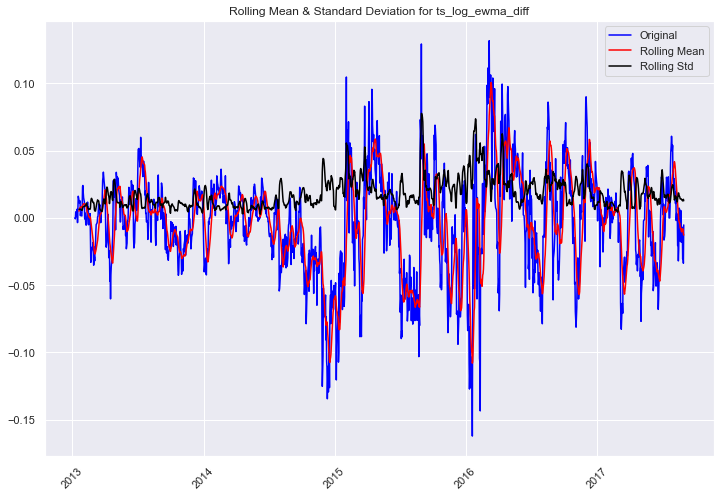

Results of Dickey-Fuller Test:
Test Statistic                -8.154986e+00
p-value                        9.472796e-13
# Lags Used                    2.000000e+00
Number of Observations Used    1.694000e+03
Critical Value (1%)           -3.434216e+00
Critical Value (5%)           -2.863248e+00
Critical Value (10%)          -2.567679e+00
dtype: float64


In [21]:
ts_transformations(oil, 'price',save_as='oil')

<div class="span5 alert alert-success">
<h3>Solution</h3>
In this case we can also use the log 1 day difference as with Poultry.
</div>    

<a id='decomposition'></a>


## Decomposition: trend, seasonality, residuals
***

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
def plot_decomposition(df, ts, trend, seasonal, residual, save_as):
    """
    Plot time series data
    """
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(df[seasonal],label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(df[residual], label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

    # Show graph
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    
    plt.savefig('img/decomposition/%s Trend, Seasonal, and Residual Decomposition of %s' %(save_as, ts))
    plt.show()
    plt.close()
  

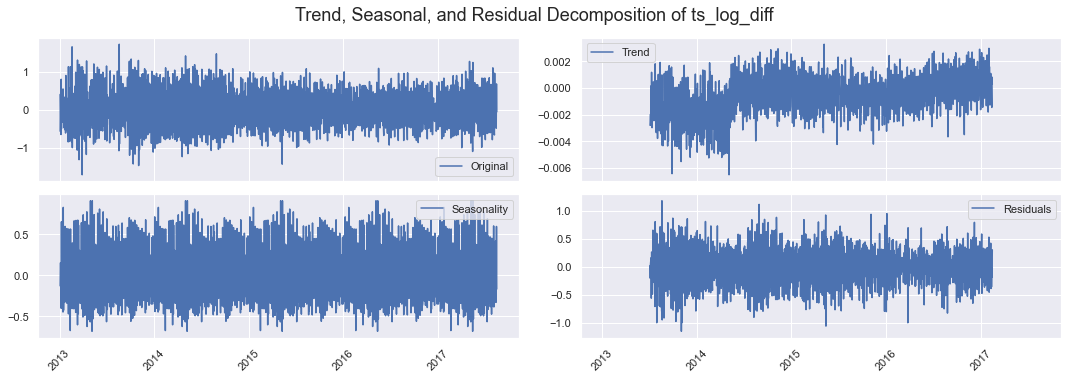

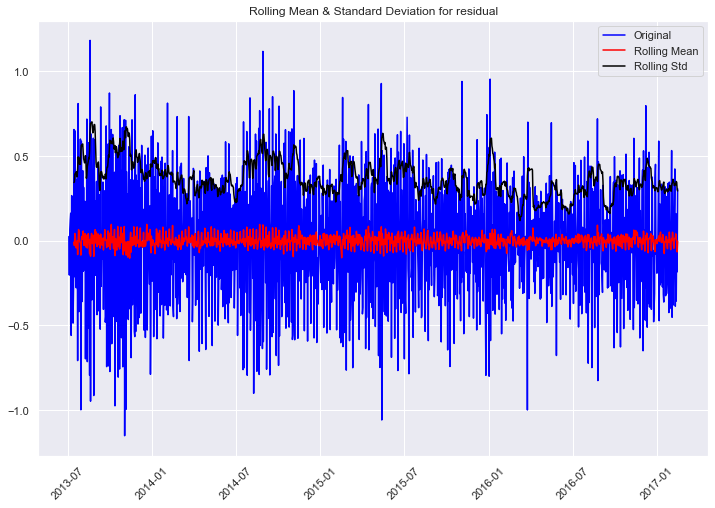

Results of Dickey-Fuller Test:
Test Statistic                -1.122558e+01
p-value                        1.964404e-20
# Lags Used                    2.200000e+01
Number of Observations Used    1.290000e+03
Critical Value (1%)           -3.435429e+00
Critical Value (5%)           -2.863783e+00
Critical Value (10%)          -2.567964e+00
dtype: float64


In [29]:
decomposition = seasonal_decompose(poultry['ts_log_diff'].iloc[1:], period = 365)

poultry.loc[:,'trend'] = decomposition.trend
poultry.loc[:,'seasonal'] = decomposition.seasonal
poultry.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = poultry, 
                   ts = 'ts_log_diff', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual',
                  save_as='poultry')

test_stationarity(df = poultry.dropna(), ts = 'residual', save_as='poultry')

In [31]:
def seasonal_decomposition(dataframe,column, family=None):
    if family != None:
        df = dataframe[dataframe['family'] == family][[column]].groupby('date').mean()
    else:
        df = dataframe.copy()
    
    decomposition = seasonal_decompose(df[column], period = 365)

    df.loc[:,'trend'] = decomposition.trend
    df.loc[:,'seasonal'] = decomposition.seasonal
    df.loc[:,'residual'] = decomposition.resid

    plot_decomposition(df = df, 
                   ts = column, 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual',
                    save_as = family)

    test_stationarity(df = df.dropna(), ts = 'residual', save_as=family)

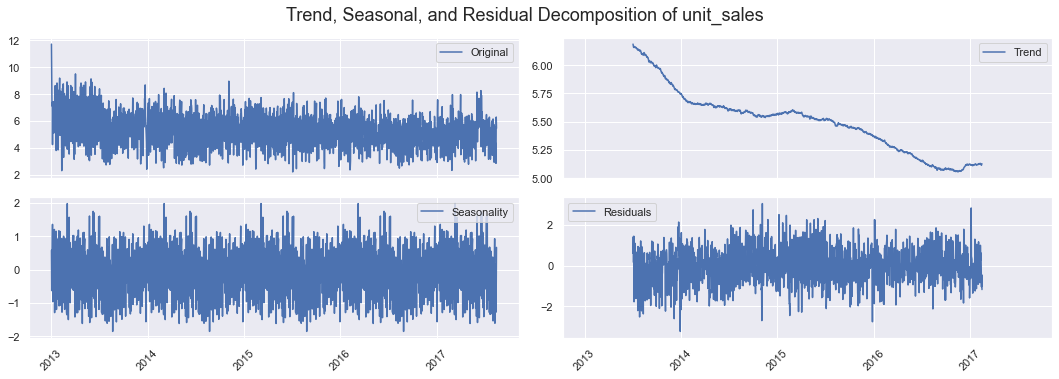

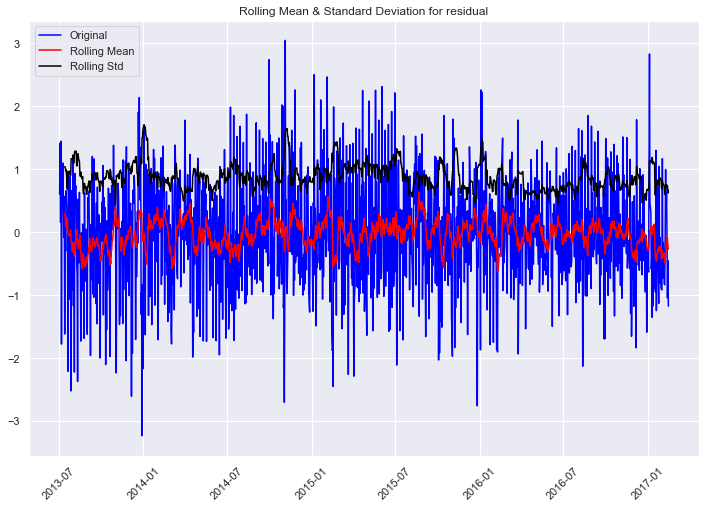

Results of Dickey-Fuller Test:
Test Statistic                -7.014137e+00
p-value                        6.801378e-10
# Lags Used                    2.000000e+01
Number of Observations Used    1.293000e+03
Critical Value (1%)           -3.435418e+00
Critical Value (5%)           -2.863778e+00
Critical Value (10%)          -2.567961e+00
dtype: float64


In [32]:
seasonal_decomposition(train, 'unit_sales', 'EGGS')

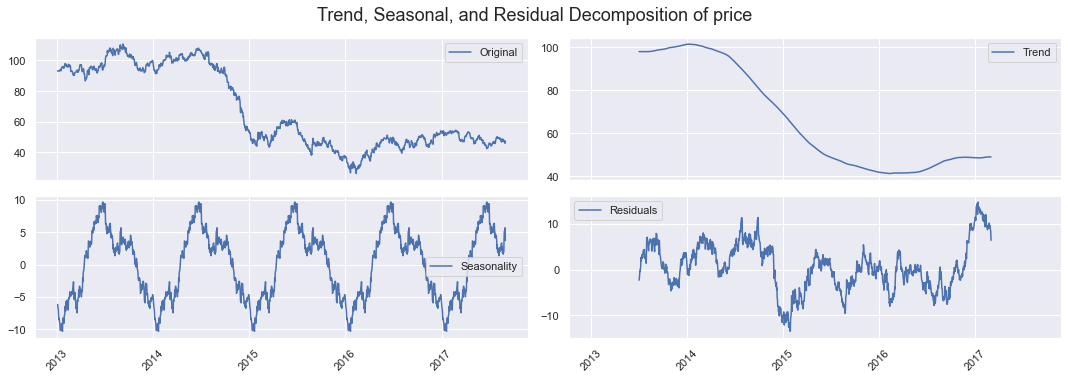

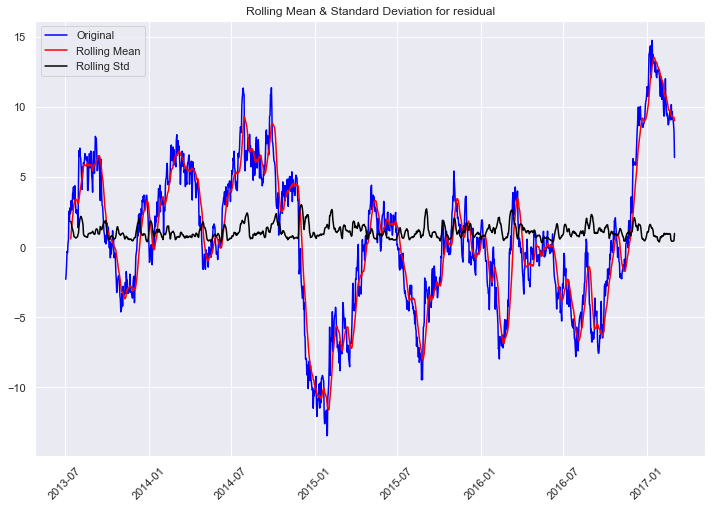

Results of Dickey-Fuller Test:
Test Statistic                   -2.750719
p-value                           0.065665
# Lags Used                       1.000000
Number of Observations Used    1337.000000
Critical Value (1%)              -3.435250
Critical Value (5%)              -2.863704
Critical Value (10%)             -2.567922
dtype: float64


In [33]:
seasonal_decomposition(oil.iloc[1:], 'price')

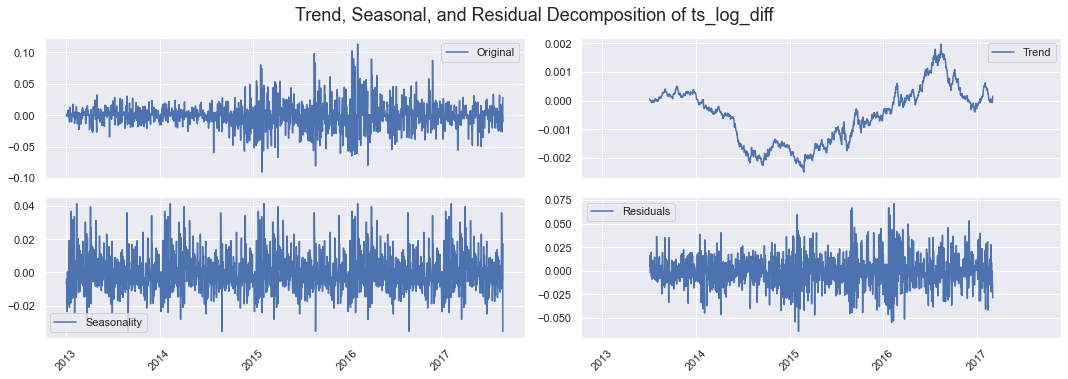

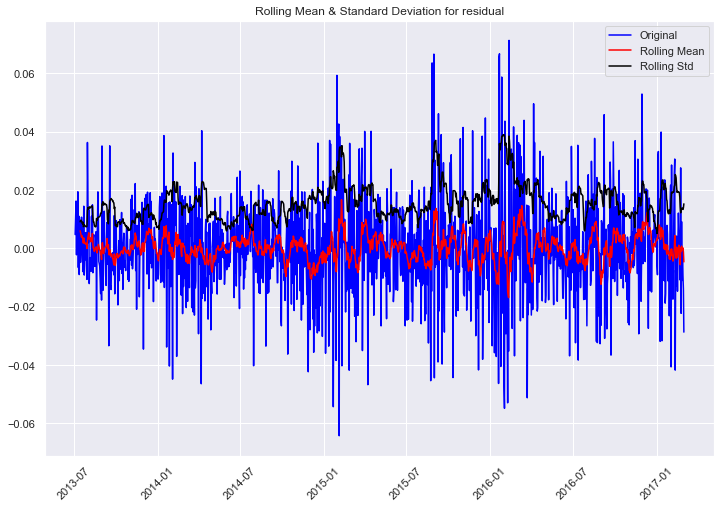

Results of Dickey-Fuller Test:
Test Statistic                  -28.167940
p-value                           0.000000
# Lags Used                       1.000000
Number of Observations Used    1336.000000
Critical Value (1%)              -3.435254
Critical Value (5%)              -2.863706
Critical Value (10%)             -2.567923
dtype: float64


In [34]:
seasonal_decomposition(oil.iloc[2:], 'ts_log_diff')

<a id='saving'></a>


## Saving the datasets
***

In [35]:
original_values = train['unit_sales']
original_values_books = train[train['family'] == 'BOOKS']['unit_sales']
original_values_poultry = train[train['family'] == 'POULTRY']['unit_sales']
original_values_oil = train['price']

In [36]:
mask = train[train['family'] == 'BOOKS']['id'].tolist()

In [37]:
#since we have a negative number we will add +2 as a constant to then do the log
books_min = round(min(books[books['unit_sales'] < 0]['unit_sales']))
books_min

-1

In [38]:
books_log = train.progress_apply(lambda x: np.log(x['unit_sales']+abs(books_min)+1) if x['id'] in mask else x['unit_sales'], axis=1)

Progress!: 100%|██████████| 2568576/2568576 [01:03<00:00, 40470.42it/s]


In [39]:
train['unit_sales'] = books_log.values

In [40]:
mask = train[train['family'] == 'POULTRY']['id'].tolist()

In [41]:
df_poultry = train[train['family'] == 'POULTRY']
poultry_min = round(min(df_poultry[df_poultry['unit_sales'] <= 0]['unit_sales']))
poultry_min

-23

In [42]:
#poultry_log_diff = train.progress_apply(lambda x: np.log(x['unit_sales']+abs(poultry_min)) if x['id'] in mask else x['unit_sales'], axis=1)

In [43]:
df_poultry['poultry_log_diff'] = df_poultry.progress_apply(lambda x: np.log(x['unit_sales']+abs(poultry_min)), axis=1)
df_poultry['poultry_log_diff'] = df_poultry['poultry_log_diff'].diff()

Progress!: 100%|██████████| 47491/47491 [00:00<00:00, 52758.52it/s]


In [44]:
train = train.reset_index().merge(df_poultry[['id','poultry_log_diff']], how='left', on='id')

In [45]:
test = train.progress_apply(lambda x: x['unit_sales'] if (np.all(pd.isnull(x['poultry_log_diff']))) else x['poultry_log_diff'],axis=1)

Progress!: 100%|██████████| 2568830/2568830 [01:55<00:00, 22214.88it/s]


In [46]:
train['unit_sales'] = test.values

In [47]:
train

date         id  item_nbr  unit_sales onpromotion  \
0       2013-01-02        578    103665         2.0     No Info   
1       2013-01-02        579    105574         8.0     No Info   
2       2013-01-02        580    105575        15.0     No Info   
3       2013-01-02        581    105577         2.0     No Info   
4       2013-01-02        582    105737         2.0     No Info   
...            ...        ...       ...         ...         ...   
2568825 2017-08-15  125396207   2114812         1.0        True   
2568826 2017-08-15  125396208   2116416         1.0       False   
2568827 2017-08-15  125396209   2122188         1.0       False   
2568828 2017-08-15  125396210   2122676         2.0       False   
2568829 2017-08-15  125396211   2124052         1.0       False   

                   family  class  perishable  price  transactions      type  \
0            BREAD/BAKERY   2712           1  93.14        2111.0  Work Day   
1               GROCERY I   1045           0  93.14        2111.0  Work Day   
2               GROCERY I   1045           0  93.14        2111.0  Work Day   
3               GROCERY I   1045           0  93.14        2111.0  Work Day   
4               GROCERY I   1044           0  93.14        2111.0  Work Day   
...                   ...    ...         ...    ...           ...       ...   
2568825          CLEANING   3020           0  47.57        1693.0  Work Day   
2568826         GROCERY I   1060           0  47.57        1693.0  Work Day   
2568827         GROCERY I   1084           0  47.57        1693.0  Work Day   
2568828         BEVERAGES   1124           0  47.57        1693.0  Work Day   
2568829  LIQUOR,WINE,BEER   1318           0  47.57        1693.0  Work Day   

         dow  poultry_log_diff  
0          2               NaN  
1          2               NaN  
2          2               NaN  
3          2               NaN  
4          2               NaN  
...      ...               ...  
2568825    1               NaN  
2568826    1               NaN  
2568827    1               NaN  
2568828    1               NaN  
2568829    1               NaN  

[2568830 rows x 13 columns]

In [48]:
oil_log_diff = oil.progress_apply(lambda x: np.log(x['price']), axis=1)
oil_log_diff = pd.DataFrame(oil_log_diff.diff())
oil_log_diff.columns = ['oil_price_log_diff']

Progress!: 100%|██████████| 1704/1704 [00:00<00:00, 33246.16it/s]


In [49]:
train = train.merge(oil_log_diff, how='left', on='date')

In [50]:
train.drop(['price','poultry_log_diff'], axis=1, inplace=True)

In [51]:
train = train.set_index('date')

In [53]:
# we need to erase the first observation of poultry
train = train[(train['id'] != 590)]

In [54]:
# finally, we save the new dataframe as a csv file.
train.to_csv('../../data/stationary/train_clean_stationary.csv')